- Aluno: Vítor Gabriel Reis Caitité
- Matrícula: 2021712430


# Implementação de um Sistema de Inferência NFN


Nesta etapa será implementada o sistema mebuloso adaptativo NFN (NEO-FUZZY-NEURON)


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from math import *
from sklearn.metrics import mean_squared_error
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import random
import collections
import pandas as pd
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline

In [27]:
class NFN(BaseEstimator, ClassifierMixin):
    def __init__(self, n_inputs, n_rules, lr = 0.8, n_epochs=100):
        self.n_rules = n_rules
        self.n_inputs = n_inputs
        self.w = np.zeros([self.n_inputs, self.n_rules])   
        self.P = np.random.randn(self.n_inputs, self.n_rules)
        self.q = np.random.randn(self.n_rules)
        self.lr = lr
        self.n_epochs = n_epochs
    
    # X - dados de entrada
    # y - saídas esperadas
    # n_epochs - maximo de épocas
    # lr - learning rate
    def fit(self, X, y_real):
        self.mse = []
        # Estrutura de repetição para número de épocas
        
        self.delta = np.zeros(X.shape[1])
        self.X_min = np.zeros(X.shape[1])
        self.X_max = np.zeros(X.shape[1])
        for j in range(X.shape[1]):
            self.X_min[j] = np.min(X[:, j])
            self.X_max[j] = np.max(X[:, j])
            self.delta[j] = (self.X_max[j] - self.X_min[j]) / (self.n_rules-1)
            
        for epoch in range(self.n_epochs):
            #X, y_real = shuffle(X, y_real)
            # Estrutura de repetição para o números de pontos
            for k in range(X.shape[0]):
                # Apresentação dos dados a rede e cálculo da saída para os parâmetros atuais
                y_hat = 0
                sum_alpha = 0 
                kk = np.zeros((X.shape[1], 2))
                mk = np.zeros((X.shape[1], 2))
                # Estrutura de repetição para o número de regras
                for i in range(X.shape[1]):
                    x_min = self.X_min[i]
                    x_max = self.X_max[i]
                    delta = self.delta[i]              
                    
                    # k1 - primeira função de pertinência ativa
                    # mk1 - valor correspondente a função ativa
                    if X[k, i] <= x_min:
                        k1 = 0
                        mk1 = 1
                    elif X[k, i] >= x_max:
                        k1 = self.n_rules - 1 - 1  #because python first index is 0
                        mk1 = 0
                    else:
                        k1 = int((X[k, i] - x_min)/delta) - 1 - 1
                        mk1 = int(-X[k, i] + x_min + k1*delta)/delta
                    
                    mk2 = 1 - mk1
                    k2 = k1 + 1
                    sum_alpha = sum_alpha + (mk1**2 + mk2**2)
                    #print(k2)
                    yi = mk1 * self.w[i, k1] + mk2 * self.w[i, k2]
                    y_hat = y_hat + yi
            
                    kk[i, :] = [int(k1), int(k2)]
                    mk[i, :] = [mk1, mk2]

                alpha = self.lr * (1 / sum_alpha)
                error = (y_hat -  y_real[k]);
        
                for i in range(X.shape[1]):
                    #print(kk[i, 0])
                    self.w[i, int(kk[i, 0])] = self.w[i, int(kk[i, 0])] - alpha * error * mk[i, 0] 
                    self.w[i, int(kk[i, 1])] = self.w[i, int(kk[i, 1])] - alpha * error * mk[i, 1];
            # Calculo do erro quadrático
            self.mse.append(mean_squared_error(y_real, self.predict(X)))
            
    def predict(self, X):
        y_hat = []
        for k in range(X.shape[0]):
            yhat = 0
            for i in range(X.shape[1]):
                x_min = self.X_min[i]
                x_max = self.X_max[i]
                delta = self.delta[i]
                # k1 - primeira função de pertinência ativa
                # mk1 - valor correspondente a função ativa
                if X[k, i] <= x_min:
                    k1 = 0
                    mk1 = 1
                elif X[k, i] >= x_max:
                    k1 = self.n_rules - 1 - 1  #because python first index is 0
                    mk1 = 0
                else:
                    k1 = int((X[k, i] - x_min)/delta) - 1 - 1
                    mk1 = int(-X[k, i] + x_min + k1*delta)/delta
                mk2 = 1 - mk1
                k2 = k1 + 1
                yi = mk1 * self.w[i, k1] + mk2 * self.w[i, k2]
                yhat = yhat + yi 
            y_hat.append(yhat)
        #print(y_hat)
        return np.array(y_hat)

# Problema 1 - Modelagem de sistema estático monovariável

Aproximar a função $y=x^2$.



## Geração dos Dados

In [3]:
# Generating Data
N = 1000
X = np.linspace(-2, 2, N).reshape(-1, 1)
y = X ** 2

## Aplicação do Anfis desenvolvido

mse: 0.0017402017951344472


Text(0, 0.5, 'MSE')

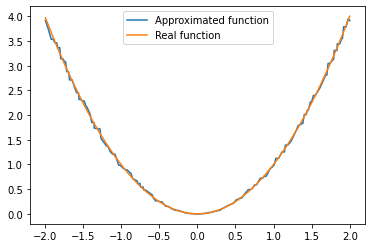

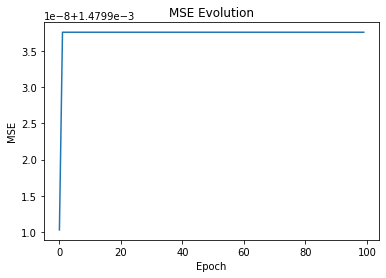

In [7]:
# Train and Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Anfis
model =NFN(n_rules = 100, n_inputs = 1, n_epochs=100, lr=0.9)
#model.initialize_params(X = X_train)
model.fit(X_train, y_train)

# Eval fis
yhat = model.predict(X_test).reshape(-1, 1)
mse = mean_squared_error(y_test, yhat)
print(f'mse: {mse}')

# Plot functions (real and approximated) 
xx, yy = zip(*sorted(zip(X_test, yhat)))
plt.plot(xx, yy)
xx, yy = zip(*sorted(zip(X_test, y_test)))
plt.plot(xx, yy)
plt.legend(["Approximated function", "Real function"])

# Plot MSE Evolution
plt.figure()
plt.plot(model.mse)
plt.title("MSE Evolution")
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Problema 2 - Modelagem de sistema estático multivariável

Modelar uma função não linear de 3 entradas:

$output = (1+x^{0.5}+y^{-1}+z^{-1.5})^2$

## Geração dos dados:

Text(0.5, 1.0, '$Y_{test}$')

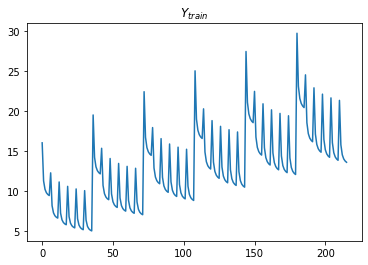

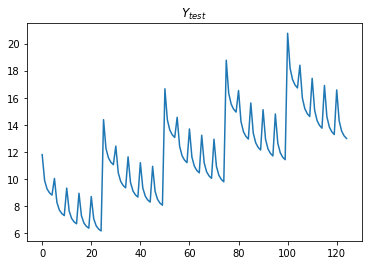

In [28]:
i = 0
X_train = []
y_train = []
X_test = []
y_test = []
for x1 in range(1, 7):
    for x2 in range(1, 7):
        for x3 in range(1, 7):
            X_train.append([x1, x2, x3])
            y_train.append((1 + x1**0.5 + x2**(-1) + x3**(-1.5))**2)
for x1 in range(1, 6):
    for x2 in range(1, 6):
        for x3 in range(1, 6):
            X_test.append([x1+0.5, x2+0.5, x3+0.5])
            y_test.append((1 + (x1+0.5)**0.5 + (x2+0.5)**(-1) + (x3+0.5)**(-1.5))**2)    
plt.plot(y_train)
plt.title("$Y_{train}$")
plt.figure()
plt.plot(y_test)
plt.title("$Y_{test}$")


## Aplicação do Anfis desenvolvido

mse: 3.3032665661654517


Text(0, 0.5, 'MSE')

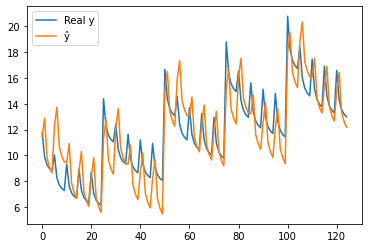

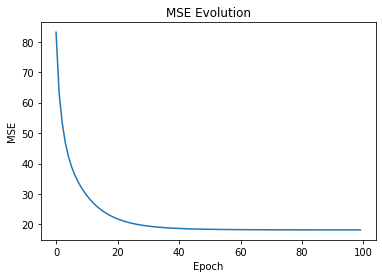

In [49]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

model = NFN(n_inputs = X_train.shape[1], n_rules = 5, n_epochs=100, lr=0.04)
model.fit(X_train, y_train)

# Eval fis
yhat = model.predict(X_test)
mse = mean_squared_error(y_test, yhat)
print(f'mse: {mse}')

# Plot functions (real and approximated) 
plt.plot(y_test)
plt.plot(yhat)
plt.legend(["Real y", "ŷ"])

# Plot MSE Evolution
plt.figure()
plt.plot(model.mse)
plt.title("MSE Evolution")
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Problema 3 - Modelo de sistema dinâmico

##  Geração dos dados

In [50]:
def g(x):
    num = x[0] * x[1] * x[2] * x[4] * (x[2] - 1) + x[3]
    den = 1 + x[2]**2 + x[3]**2
    return num / den

In [51]:
K = np.linspace(0, 1000, 6000)
u = []
for k in K:
    if k<=500:
        u.append(np.sin(2*np.pi * k / 250))
    else:
        u.append(0.8 * (np.sin(2*np.pi * k / 250)) + 0.2 * np.sin(2*np.pi * k/25))

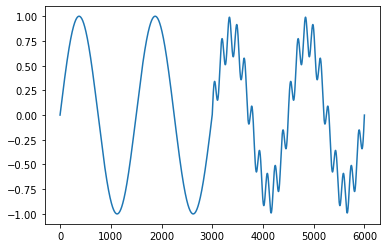

In [52]:
plt.plot(u)

In [53]:
X=[]
y=[]
x = [0, 0, 0, u[0], 0]
X.append(x)
y.append(g(x))
x = [g(x), y[0], 0, u[1], u[0]]
X.append(x)
y.append(g(x))
for k in range(2, 6000):
    x = [g(x), y[k-1], y[k-2], u[k], u[k-1]]
    X.append(x)
    y.append(g(x))
    
X = np.array(X)
y = np.array(y)

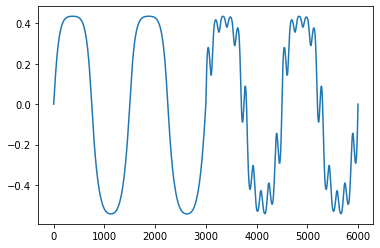

In [54]:
plt.plot(y)

## Aplicação do Anfis desenvolvido

In [55]:
# Train and Test split
test_idx = np.sort(np.random.randint(0, 6000, size=1000))
X_test = X[test_idx]
y_test = y[test_idx]
X_train = []
y_train = []

for idx in range(6000):
    if idx not in test_idx:
        X_train.append(X[idx])
        y_train.append(y[idx])

X_train = np.array(X_train)
y_train = np.array(y_train)

mse: 0.00042065748123988036


Text(0, 0.5, 'MSE')

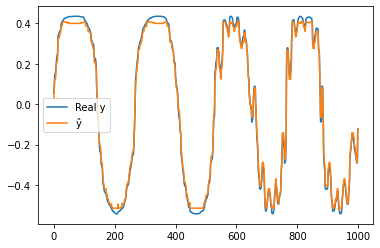

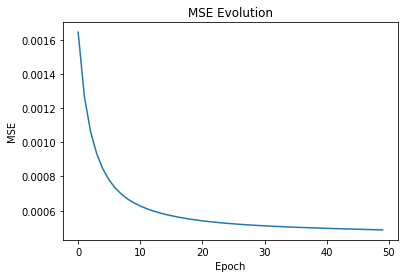

In [58]:
# Anfis
model = NFN(n_rules = 40, n_inputs = X_train.shape[1], n_epochs=50, lr=0.9)
model.fit(X_train, y_train)

# Eval fis
yhat = model.predict(X_test).reshape(-1, 1)
mse = mean_squared_error(y_test, yhat)
print(f'mse: {mse}')

# Plot functions (real and approximated) 
plt.plot(y_test)
plt.plot(yhat)
plt.legend(["Real y", "ŷ"])

# Plot MSE Evolution
plt.figure()
plt.plot(model.mse)
plt.title("MSE Evolution")
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Problema 4 - Previsão de uma série temporal caótica

## Geração de dados
Esse problema consiste em aproximação de uma série temporal caótica descrita pela seguinte função:

$\hat{x} = \frac{0.2x(t-\tau)}{1+x^{10}(t-\tau)} - 0.1x(t)$

As entradas desse problema são variáveis x(t), x(t-6), x(t-12) e x(t-18) e saída x(t+6). E esses dados x(t) foram obtidas da série temporal Mackey-Glass. Para a geração dos dados utilizou-se um intervalo de t=118 até 1117.

In [59]:
# code from: https://github.com/mila-iqia/summerschool2015/blob/master/rnn_tutorial/synthetic.py
def mackey_glass(sample_len=1000, tau=17, seed=None, n_samples = 1):
    delta_t = 10
    history_len = tau * delta_t 
    # Initial conditions for the history of the system
    timeseries = 1.2
    
    if seed is not None:
        np.random.seed(seed)
    samples = []
    
    for _ in range(n_samples):
        history = collections.deque(1.2 * np.ones(history_len) + 0.2 * \
                                    (np.random.rand(history_len) - 0.5))
        # Preallocate the array for the time-series
        inp = np.zeros((sample_len,1))
        
        for timestep in range(sample_len):
            for _ in range(delta_t):
                xtau = history.popleft()
                history.append(timeseries)
                timeseries = history[-1] + (0.2 * xtau / (1.0 + xtau ** 10) - \
                             0.1 * history[-1]) / delta_t
            inp[timestep] = timeseries
        
        # Squash timeseries through tanh
        inp = np.tanh(inp - 1)
        samples.append(inp)
    return samples

serie = mackey_glass(sample_len=1130, tau=17, seed=None, n_samples = 1)[0]

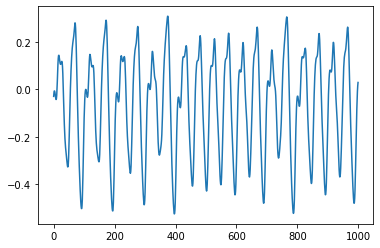

In [60]:
def x_hat(t, tau, x):
    x_hat = 0.2*x[t-tau]/(1+x^10*(t-tau))
    return x_hat

t = np.linspace(118, 1117, 1000)
X=[]
y=[]
for ti in t:
    x = [serie[int(ti)-18], serie[int(ti)-12], serie[int(ti)-6], serie[int(ti)]]
    X.append(x)
    y.append(serie[int(ti)+6])
plt.plot(y)

X = np.array(X)
y = np.array(y)

## Aplicação do Anfis desenvolvido

In [61]:
# Train and Test split
test_idx = np.sort(np.random.randint(0, 1000, size=100))
X_test = X[test_idx]
X_test = X_test.reshape([X_test.shape[0], -1])
y_test = y[test_idx]
X_train = []
y_train = []

for idx in range(1000):
    if idx not in test_idx:
        X_train.append(X[idx])
        y_train.append(y[idx])

X_train = np.array(X_train)
X_train = X_train.reshape([X_train.shape[0], -1])
y_train = np.array(y_train)

mse: 0.0004075498362574023


Text(0, 0.5, 'MSE')

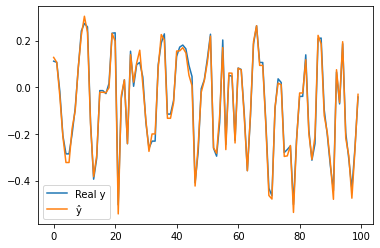

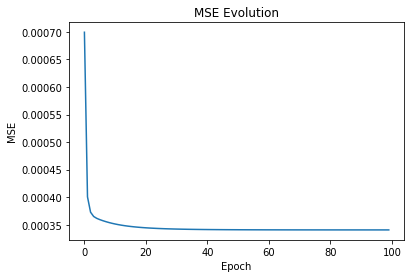

In [62]:
# Anfis
model = NFN(n_rules = 50, n_inputs = 4, n_epochs=100, lr=0.9)
model.fit(X_train, y_train)

# Eval fis
yhat = model.predict(X_test).reshape(-1, 1)
mse = mean_squared_error(y_test, yhat)
print(f'mse: {mse}')

# Plot functions (real and approximated) 
plt.plot(y_test)
plt.plot(yhat)
plt.legend(["Real y", "ŷ"])

# Plot MSE Evolution
plt.figure()
plt.plot(model.mse)
plt.title("MSE Evolution")
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Problema 5 - Problema de Regressão de um Data Set da UCI.

O data set escolhido para este exercício foi o "Airfoil Self-Noise". Essa base de dados contém  1503 instâncias. Foram utilizadas 5 variáveis de entrada e a variável a ser prevista foi a nível de pressão sonora, em decibéis.

## Leitura e pré-processamento dos dados

In [67]:
dataset = pd.read_csv('data/airfoil_self_noise.dat', sep='\t', header=None)
dataset = dataset.replace("?", np.nan)
dataset = dataset.dropna()
dataset

,0,1,2,3,4,5
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


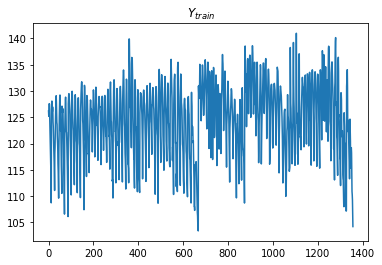

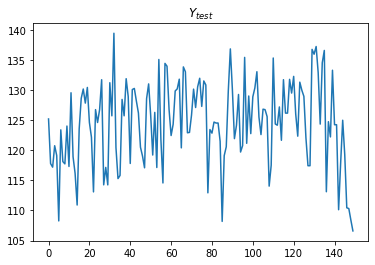

In [68]:
y = dataset[5].to_numpy()
X = dataset.drop([5], axis='columns').to_numpy()
normalizer = MinMaxScaler()
X = normalizer.fit_transform(X)
y = np.array(y.tolist())

test_idx = np.sort(np.random.randint(0, X.shape[0], size=int(X.shape[0]*0.1)))
X_test = X[test_idx]
y_test = y[test_idx]
X_train = []
y_train = []

for idx in range(X.shape[0]):
    if idx not in test_idx:
        X_train.append(X[idx])
        y_train.append(y[idx])
X_train = np.array(X_train)
y_train = np.array(y_train)

plt.plot(y_train)
plt.title('$Y_{train}$')
plt.figure()
plt.plot(y_test)
plt.title('$Y_{test}$')

## Aplicação do Anfis desenvolvido

mse: 23.484143711747777


Text(0, 0.5, 'MSE')

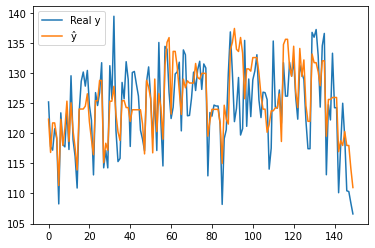

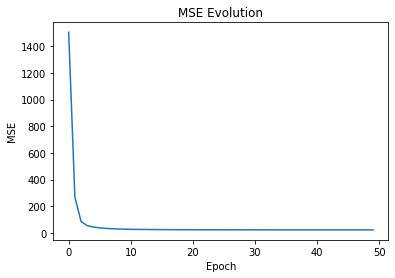

In [95]:
# Anfis
model = NFN(n_rules = 18, n_inputs = X_train.shape[1], n_epochs=50, lr=0.02)
model.fit(X_train, y_train)

# Eval fis
yhat = model.predict(X_test).reshape(-1, 1)
mse = mean_squared_error(y_test, yhat)
print(f'mse: {mse}')

# Plot functions (real and approximated) 
plt.plot(y_test)
plt.plot(yhat)
plt.legend(["Real y", "ŷ"])

# Plot MSE Evolution
plt.figure()
plt.plot(model.mse)
plt.title("MSE Evolution")
plt.xlabel("Epoch")
plt.ylabel("MSE")